## 0. Import Necessary Modules

In [4]:
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import cv2 as cv

In [6]:
from altusi.utils.logger import *

## 1. Project Parameters

In [7]:
WIDER_PATH = 'WIDER'
IMAGE_PATH = f'{WIDER_PATH}/JPEGImages'
ANNO_PATH = f'{WIDER_PATH}/Annotations'

## 2. Create LST File

In [17]:
def write_line(img_path, img_shape, bboxes, ids, idx):
    H, W, C = img_shape
    
    A, B, C, D = 4, 5, W, H
    
    labels = np.hstack((ids.reshape(-1, 1), bboxes)).astype('float')
    
    labels[:, (1, 3)] /= float(W)
    labels[:, (2, 4)] /= float(H)
    
    labels = labels.flatten().tolist()
    
    str_idx = [str(idx)]
    str_header = [str(_) for _ in [A, B, C, D]]
    str_labels = [str(_) for _ in labels]
    str_path = [img_path]
    
    line = '\t'.join(str_idx + str_header + str_labels + str_path) + '\n'

    return line

In [51]:
type_dirs = ['train', 'val']

for type_dir in type_dirs:
    file_path = f'{WIDER_PATH}/{type_dir}/label.txt'

    lines = open(file_path, 'r').read().strip().split('\n')

    image_shapes = []
    image_fnames = []
    bboxes_lst = []
    IDs_lst = []
    for i, line in enumerate(lines):
        if line[0] == '#':
            sub_dir, image_fname = line[2:].split('/')
            image_fnames.append(image_fname)

            image_shape = cv.imread(f'{IMAGE_PATH}/{image_fname}').shape
            if image_shape is None:
                print(image_fname)
            image_shapes.append(image_shape)

            IDs = []
            bboxes = []
            j = i+1
            while j < len(lines) and lines[j][0] != '#':
                bbox = np.array(list(map(int, lines[j].split(' ')[:4])))

                bbox[2:] += bbox[:2]

                IDs.append(0)
                bboxes.append(bbox)
                j += 1

            IDs_lst.append(np.array(IDs))
            bboxes_lst.append(np.array(bboxes))
            
    LOG(INFO, type_dir)
    LOG(INFO, '\tno. samples:', len(image_fnames))
            
    with open(type_dir + '.lst', 'w') as fw:
        for i, image_fname in enumerate(image_fnames):
            line = write_line(image_fname, 
                              image_shapes[i],
                              bboxes_lst[i],
                              IDs_lst[i],
                              i)

            fw.write(line)

[2019-08-29 17:03:52] [INFO]  train
[2019-08-29 17:03:52] [INFO]  	no. samples: 12876
[2019-08-29 17:04:10] [INFO]  val
[2019-08-29 17:04:10] [INFO]  	no. samples: 3222


## 3. Create REC File

In [48]:
#python /path/to/incubator-mxnet/tools/im2rec.py train.lst WIDER/JPEGImages/ --pass-through --pack-label
#python /path/to/incubator-mxnet/tools/im2rec.py val.lst WIDER/JPEGImages/ --pass-through --pack-label

## 4. Test Recorded Dataset

### 4.1 Test train set

In [64]:
from gluoncv.data import RecordFileDetection
from gluoncv import utils

class_names = ['person']

train_dataset = RecordFileDetection('train.rec', coord_normalized=True)

LOG(INFO, 'no. samples:', len(train_dataset))

[2019-08-29 17:07:39] [INFO]  no. samples: 12876


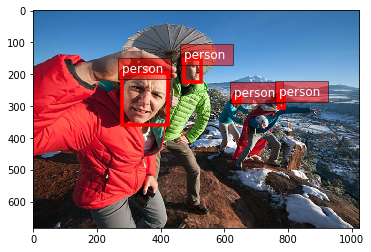

In [68]:
rnd_idx = np.random.randint(len(train_dataset))

image = train_dataset[rnd_idx][0]
label = train_dataset[rnd_idx][1]
bboxes = label[:, :4]
IDs = label[:, -1]

ax = utils.viz.plot_bbox(image, bboxes, 
                         labels=IDs,
                         class_names=class_names)
plt.show()

### 4.1 Test val set

In [69]:
val_dataset = RecordFileDetection('val.rec', coord_normalized=True)

LOG(INFO, 'no. samples:', len(val_dataset))

[2019-08-29 17:09:09] [INFO]  no. samples: 3222


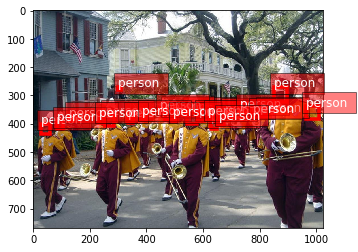

In [74]:
rnd_idx = np.random.randint(len(val_dataset))

image = val_dataset[rnd_idx][0]
label = val_dataset[rnd_idx][1]
bboxes = label[:, :4]
IDs = label[:, -1]

ax = utils.viz.plot_bbox(image, bboxes, 
                         labels=IDs,
                         class_names=class_names)
plt.show()